# Train base LSTM model for trajectory prediction

In [1]:
import geopandas as gpd
import pandas as pd
import copy
import os
import warnings
import random
from pprint import pprint
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import json
import pickle

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, \
    classification_report
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
if not os.path.exists('models'):
    os.makedirs('models')

In [4]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X_seq = self.X.iloc[idx].values
        y_val = self.y.iloc[idx]

        X_tensor = torch.tensor([item for item in X_seq], dtype=torch.float32)
        y_tensor = torch.tensor(y_val, dtype=torch.float32)

        return X_tensor, y_tensor

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [6]:
H3_RESOLUTION = 8
seq_length = 15
data_path = 'input_data'
path = f'data_res{H3_RESOLUTION}_seq{seq_length}'
path = os.path.join(data_path, path)

In [7]:
with open(os.path.join(path, 'train_small.pkl'), 'rb') as f:
    X_train, y_train = pickle.load(f)

In [8]:
with open(os.path.join(path, 'test_small.pkl'), 'rb') as f:
    X_test, y_test = pickle.load(f)

In [9]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(200000, 15) (200000,)
(40000, 15) (40000,)


In [10]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

y_train = pd.Series(y_train)
y_test = pd.Series(y_test)

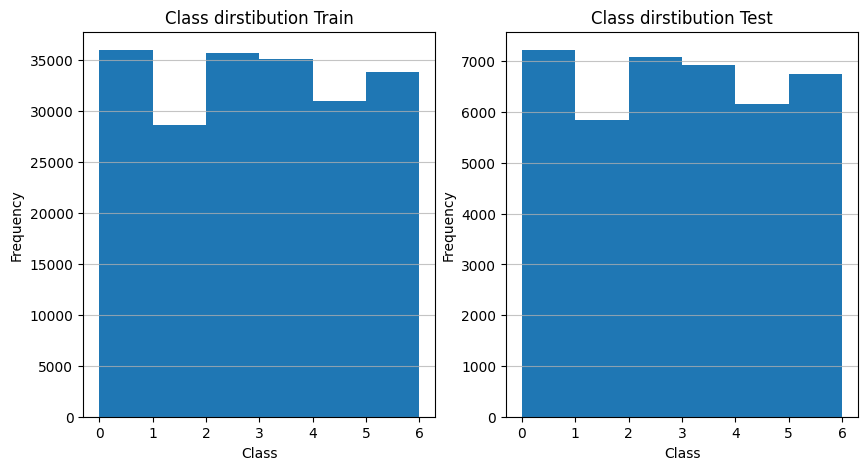

In [11]:
dist = []
for i in y_train:
    id_max = np.argmax(i)
    dist.append(id_max)

test_dist = []
for i in y_test:
    id_max = np.argmax(i)
    test_dist.append(id_max)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].hist(dist, bins=range(7))
ax[0].set_title('Class dirstibution Train')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')
ax[0].grid(axis='y', alpha=0.75)

ax[1].hist(test_dist, bins=range(7))
ax[1].set_title('Class dirstibution Test')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')
ax[1].grid(axis='y', alpha=0.75)
plt.show()

In [12]:
train_dataset = SequenceDataset(X_train, y_train)
test_dataset = SequenceDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Train model

In [13]:
input_size = len(X_train.iloc[0][0])
hidden_size = 128
output_size = 6
num_layers = 2
dropout_rate = 0.5

model = LSTMModel(input_size, hidden_size, output_size, num_layers, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 101.38batch/s, val_loss=1.38]


Epoch [1/60], Loss: 1.6350, Val Loss: 1.3724


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 95.17batch/s, val_loss=1.2]


Epoch [2/60], Loss: 1.3112, Val Loss: 1.1601


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 96.30batch/s, val_loss=1.09]


Epoch [3/60], Loss: 1.1870, Val Loss: 1.0638


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 98.06batch/s, val_loss=1.12]


Epoch [4/60], Loss: 1.1189, Val Loss: 1.0164


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 87.99batch/s, val_loss=1.16]


Epoch [5/60], Loss: 1.0741, Val Loss: 0.9765


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 101.40batch/s, val_loss=1.09]


Epoch [6/60], Loss: 1.0411, Val Loss: 0.9536


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 94.79batch/s, val_loss=1.08]


Epoch [7/60], Loss: 1.0146, Val Loss: 0.9299


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 93.46batch/s, val_loss=1.12]


Epoch [8/60], Loss: 0.9951, Val Loss: 0.9218


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 92.25batch/s, val_loss=1.05]


Epoch [9/60], Loss: 0.9766, Val Loss: 0.9030


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 86.45batch/s, val_loss=1.03]


Epoch [10/60], Loss: 0.9605, Val Loss: 0.8905


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 95.10batch/s, val_loss=0.979]


Epoch [11/60], Loss: 0.9505, Val Loss: 0.8846


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 89.75batch/s, val_loss=1.06]


Epoch [12/60], Loss: 0.9405, Val Loss: 0.8776


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 89.82batch/s, val_loss=1.04]


Epoch [13/60], Loss: 0.9287, Val Loss: 0.8738


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 83.45batch/s, val_loss=0.975]


Epoch [14/60], Loss: 0.9189, Val Loss: 0.8744


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 87.21batch/s, val_loss=1.08]


Epoch [15/60], Loss: 0.9121, Val Loss: 0.8580


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:15<00:00, 82.82batch/s, val_loss=1.1]


Epoch [16/60], Loss: 0.9049, Val Loss: 0.8558


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:15<00:00, 80.03batch/s, val_loss=1.07]


Epoch [17/60], Loss: 0.8975, Val Loss: 0.8525


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:15<00:00, 80.85batch/s, val_loss=1.05]


Epoch [18/60], Loss: 0.8919, Val Loss: 0.8498


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 84.59batch/s, val_loss=1.11]


Epoch [19/60], Loss: 0.8857, Val Loss: 0.8510


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:16<00:00, 75.74batch/s, val_loss=0.984]


Epoch [20/60], Loss: 0.8813, Val Loss: 0.8427


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 84.05batch/s, val_loss=1.08]


Epoch [21/60], Loss: 0.8753, Val Loss: 0.8451


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:15<00:00, 80.65batch/s, val_loss=1.05]


Epoch [22/60], Loss: 0.8706, Val Loss: 0.8352


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:15<00:00, 79.52batch/s, val_loss=1.06]


Epoch [23/60], Loss: 0.8670, Val Loss: 0.8327


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 85.69batch/s, val_loss=1.01]


Epoch [24/60], Loss: 0.8608, Val Loss: 0.8382


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 94.66batch/s, val_loss=0.949]


Epoch [25/60], Loss: 0.8597, Val Loss: 0.8322


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 92.80batch/s, val_loss=0.983]


Epoch [26/60], Loss: 0.8546, Val Loss: 0.8265


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 101.55batch/s, val_loss=1.12]


Epoch [27/60], Loss: 0.8511, Val Loss: 0.8347


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 88.33batch/s, val_loss=1.06]


Epoch [28/60], Loss: 0.8481, Val Loss: 0.8364


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 94.10batch/s, val_loss=1.08]


Epoch [29/60], Loss: 0.8448, Val Loss: 0.8248


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 93.06batch/s, val_loss=1.07]


Epoch [30/60], Loss: 0.8421, Val Loss: 0.8169


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 100.33batch/s, val_loss=1.17]


Epoch [31/60], Loss: 0.8376, Val Loss: 0.8240


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 102.25batch/s, val_loss=1.16]


Epoch [32/60], Loss: 0.8349, Val Loss: 0.8223


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 109.21batch/s, val_loss=1.09]


Epoch [33/60], Loss: 0.8336, Val Loss: 0.8187


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 85.06batch/s, val_loss=1.15]


Epoch [34/60], Loss: 0.8316, Val Loss: 0.8197


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 93.48batch/s, val_loss=1.1]


Epoch [35/60], Loss: 0.8290, Val Loss: 0.8198


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 110.33batch/s, val_loss=1.08]


Epoch [36/60], Loss: 0.8258, Val Loss: 0.8156


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:18<00:00, 66.80batch/s, val_loss=1.13]


Epoch [37/60], Loss: 0.8236, Val Loss: 0.8131


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:19<00:00, 65.56batch/s, val_loss=1.13]


Epoch [38/60], Loss: 0.8236, Val Loss: 0.8160


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:15<00:00, 78.77batch/s, val_loss=1.12]


Epoch [39/60], Loss: 0.8195, Val Loss: 0.8190


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:16<00:00, 75.63batch/s, val_loss=1.07]


Epoch [40/60], Loss: 0.8190, Val Loss: 0.8144


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:18<00:00, 69.03batch/s, val_loss=1.06]


Epoch [41/60], Loss: 0.8159, Val Loss: 0.8130


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 96.18batch/s, val_loss=1.13]


Epoch [42/60], Loss: 0.8138, Val Loss: 0.8163


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 94.62batch/s, val_loss=1.07]


Epoch [43/60], Loss: 0.8134, Val Loss: 0.8184


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 89.17batch/s, val_loss=1.05]


Epoch [44/60], Loss: 0.8119, Val Loss: 0.8112


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 88.49batch/s, val_loss=1.03]


Epoch [45/60], Loss: 0.8091, Val Loss: 0.8074


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:15<00:00, 82.33batch/s, val_loss=1.1]


Epoch [46/60], Loss: 0.8088, Val Loss: 0.8162


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 95.59batch/s, val_loss=1.21]


Epoch [47/60], Loss: 0.8061, Val Loss: 0.8117


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 104.85batch/s, val_loss=1.08]


Epoch [48/60], Loss: 0.8045, Val Loss: 0.8056


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 86.86batch/s, val_loss=1.19]


Epoch [49/60], Loss: 0.8030, Val Loss: 0.8176


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 96.63batch/s, val_loss=1.06]


Epoch [50/60], Loss: 0.8018, Val Loss: 0.8115


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 95.54batch/s, val_loss=1.11]


Epoch [51/60], Loss: 0.8013, Val Loss: 0.8091


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 96.31batch/s, val_loss=1.1]


Epoch [52/60], Loss: 0.7990, Val Loss: 0.8099


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 97.08batch/s, val_loss=1.21]


Epoch [53/60], Loss: 0.7969, Val Loss: 0.8115


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 108.58batch/s, val_loss=1.15]


Epoch [54/60], Loss: 0.7954, Val Loss: 0.8149


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 106.12batch/s, val_loss=1.02]


Epoch [55/60], Loss: 0.7949, Val Loss: 0.8118


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 102.59batch/s, val_loss=1.01]


Epoch [56/60], Loss: 0.7938, Val Loss: 0.8059


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:12<00:00, 103.05batch/s, val_loss=1.08]


Epoch [57/60], Loss: 0.7925, Val Loss: 0.8018


Validation: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:11<00:00, 109.23batch/s, val_loss=1.08]


Epoch [58/60], Loss: 0.7903, Val Loss: 0.8067


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:13<00:00, 94.85batch/s, val_loss=1.13]


Epoch [59/60], Loss: 0.7896, Val Loss: 0.8095


Validation: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1250/1250 [00:14<00:00, 87.83batch/s, val_loss=1.11]


Epoch [60/60], Loss: 0.7895, Val Loss: 0.8098


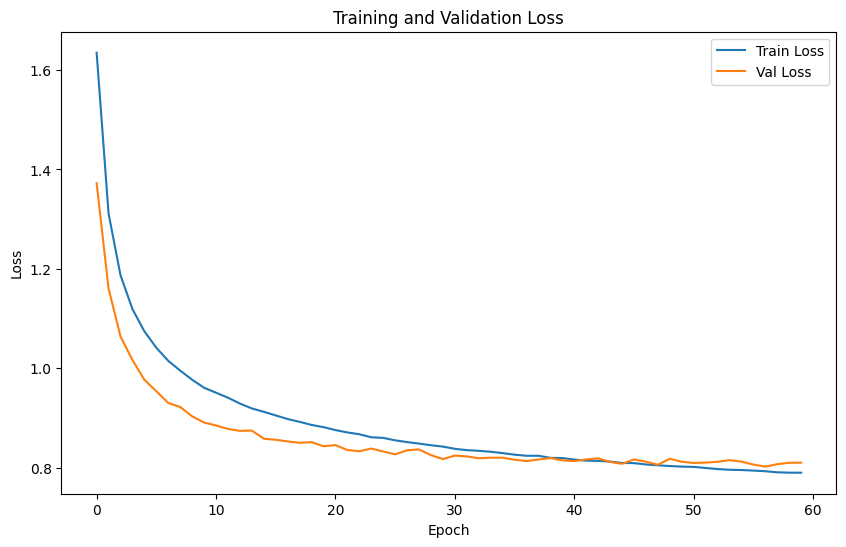

In [14]:
# Training loop with early stopping
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0

patience = 10
num_epochs = 60

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch")
    for i, (inputs, targets) in enumerate(train_loader_tqdm):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        predicted_one_hot = torch.nn.functional.one_hot(preds, num_classes=7).float()
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        train_loader_tqdm.set_postfix(loss=loss.item())

    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    # Validation loop
    model.eval()
    val_loss = 0.0

    # Dodanie tqdm do pętli batch'y walidacyjnych
    test_loader_tqdm = tqdm(test_loader, desc="Validation", unit="batch")
    with torch.no_grad():
        for inputs, targets in test_loader_tqdm:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            # Aktualizacja opisu tqdm dla batch'y walidacyjnych
            test_loader_tqdm.set_postfix(val_loss=loss.item())

    val_loss /= len(test_loader)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'model_{H3_RESOLUTION}_{seq_length}.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

# best model
model.load_state_dict(torch.load(f'model_{H3_RESOLUTION}_{seq_length}.pth'))

# Train/test plot
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Test metrics

In [21]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())
true_labels = np.array(true_labels)
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.array(predicted_labels)

In [22]:
test_accuracy = accuracy_score(true_labels, predicted_labels)
test_precision = precision_score(true_labels, predicted_labels, average='weighted')
test_recall = recall_score(true_labels, predicted_labels, average='weighted')
test_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.76      0.73      0.74      7222
           1       0.72      0.72      0.72      5835
           2       0.73      0.73      0.73      7094
           3       0.72      0.75      0.74      6933
           4       0.75      0.71      0.73      6169
           5       0.69      0.72      0.70      6747

    accuracy                           0.73     40000
   macro avg       0.73      0.73      0.73     40000
weighted avg       0.73      0.73      0.73     40000



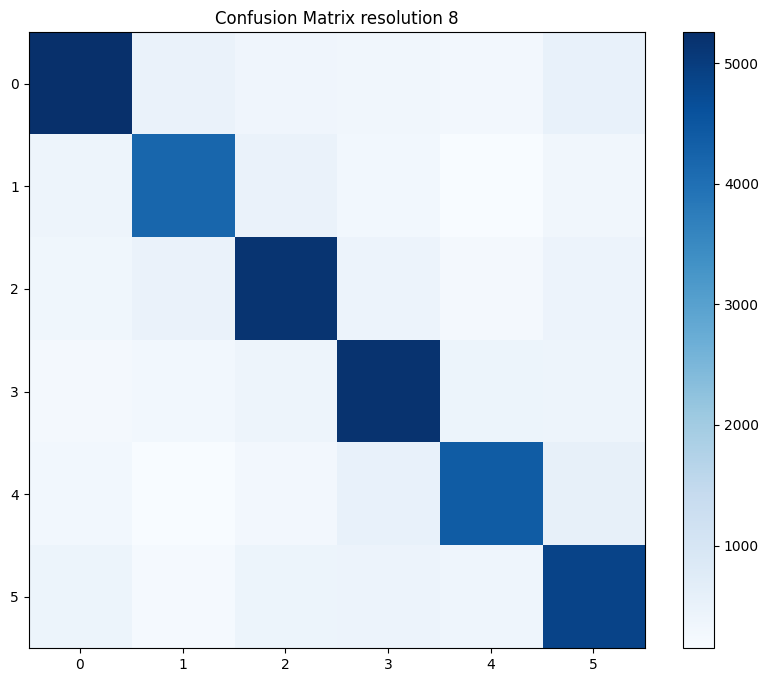

In [24]:
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix(true_labels, predicted_labels), cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.title(f'Confusion Matrix resolution {H3_RESOLUTION}')
plt.savefig(f'conf_matrix_res{H3_RESOLUTION}.pdf')
plt.show()

# Train metrics

In [18]:
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for inputs, targets in train_loader:
        inputs = inputs.to(device)
        targets = targets.to(device).long()

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        true_labels.extend(targets.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

true_labels = np.array(true_labels)
true_labels = np.argmax(true_labels, axis=1)
predicted_labels = np.array(predicted_labels)

train_accuracy = accuracy_score(true_labels, predicted_labels)
train_precision = precision_score(true_labels, predicted_labels, average='weighted')
train_recall = recall_score(true_labels, predicted_labels, average='weighted')
train_f1 = f1_score(true_labels, predicted_labels, average='weighted')

print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.81      0.77      0.79     35952
           1       0.79      0.78      0.78     28598
           2       0.78      0.79      0.78     35690
           3       0.78      0.81      0.79     35064
           4       0.79      0.77      0.78     30909
           5       0.74      0.76      0.75     33787

    accuracy                           0.78    200000
   macro avg       0.78      0.78      0.78    200000
weighted avg       0.78      0.78      0.78    200000



In [19]:
headers = ['Metric', 'Train', 'Test']
data = [
    ['Accuracy', train_accuracy, test_accuracy],
    ['Precision', train_precision, test_precision],
    ['Recall', train_recall, test_recall],
    ['F1', train_f1, test_f1]
]

print(tabulate(data, headers=headers, tablefmt='fancy_grid'))

╒═══════════╤══════════╤══════════╕
│ Metric    │    Train │     Test │
╞═══════════╪══════════╪══════════╡
│ Accuracy  │ 0.78016  │ 0.726375 │
├───────────┼──────────┼──────────┤
│ Precision │ 0.780751 │ 0.727103 │
├───────────┼──────────┼──────────┤
│ Recall    │ 0.78016  │ 0.726375 │
├───────────┼──────────┼──────────┤
│ F1        │ 0.78024  │ 0.726502 │
╘═══════════╧══════════╧══════════╛


# Save results

In [20]:
results = {
    f'model_res{H3_RESOLUTION}_seq{seq_length}': {
        'train': {
            'accuracy': train_accuracy,
            'precision': train_precision,
            'recall': train_recall,
            'f1': train_f1
        },

        'test': {
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1': test_f1
        }
    }
}

In [ ]:
with open('results_small.json', 'a') as f:
    json.dump(results, f, indent=4)